In [1]:
import os
from dotenv import load_dotenv

# from datetime import datetime, timedelta
import pandas as pd
# import matplotlib.pyplot as plt

# from sklearn.metrics import mean_squared_error, r2_score
import hopsworks
import numpy as np
# from functions import util

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt


/opt/anaconda3/envs/crypto-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
load_dotenv()
os.environ["HOPSWORKS_API_KEY"] = os.getenv("HOPSWORKS_API_KEY")
project = hopsworks.login()

fs = project.get_feature_store() 

2024-12-26 21:35:41,587 INFO: Initializing external client
2024-12-26 21:35:41,588 INFO: Base URL: https://c.app.hopsworks.ai:443
2024-12-26 21:35:43,353 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1164448


In [3]:
solana_feature_group = fs.get_feature_group(
    name="solana",  
    version=1
)

# Step 3: Read the data from the feature group
solana_df = solana_feature_group.read().sort_values(by='timestamp', inplace=False).reset_index(drop=True)
solana_df['open_diff'] = solana_df['open'].diff().fillna(0)


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.78s) 


In [4]:
# Step 2: Retrieve the feature group by name and version
bitcoin_feature_group = fs.get_feature_group(
    name="bitcoin",  
    version=1
)

# Step 3: Read the data from the feature group
bitcoin_df = bitcoin_feature_group.read().sort_values(by='timestamp', inplace=False).reset_index(drop=True)
bitcoin_df['open_diff'] = bitcoin_df['open'].diff()

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.92s) 


In [5]:
fs = project.get_feature_store(name='kth_lab1_2024_featurestore')
fng_feature_group = fs.get_feature_group('f_n_g_index', version=6)
fng_df = fng_feature_group.read()
fng_df['timestamp'] = fng_df['date'].astype('int64')/ 10**6 # Convert nanoseconds to seconds
fng_df = fng_df.sort_values(by='timestamp', inplace=False).reset_index(drop=True)
fng_df.drop(columns=["date"], inplace=True)
fng_labels_to_numbers_map={"Extreme Fear":0, "Fear":1, "Neutral":2, "Greed":3, "Extreme Greed":4} 
fng_numbers_to_labels_map={0:"Extreme Fear", 1:"Fear", 2:"Neutral", 3:"Greed", 4:"Extreme Greed"} 

fng_df['fng_classification'] = fng_df['fng_classification'].replace(fng_labels_to_numbers_map)
fng_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.78s) 


,fng_value,fng_classification,timestamp
0,30,1,1.517443e+09
1,15,0,1.517530e+09
2,40,1,1.517616e+09
3,24,0,1.517702e+09
4,11,0,1.517789e+09
...,...,...,...
2509,75,3,1.734566e+09
2510,74,3,1.734653e+09
2511,73,3,1.734739e+09
2512,73,3,1.734826e+09


In [6]:

all_data = pd.merge(solana_df, bitcoin_df, how='inner', on="timestamp",suffixes=('_solana', '_bitcoin'))  
all_data = pd.merge(all_data, fng_df, how='inner', on="timestamp")

# target = all_data["open_solana"]
# all_data = all_data.drop(["open_solana"], axis=1, inplace=False)
all_data


,timestamp,open_solana,high_solana,low_solana,close_solana,volume_solana,volume_buy_solana,volume_sell_solana,open_diff_solana,open_bitcoin,high_bitcoin,low_bitcoin,close_bitcoin,volume_bitcoin,volume_buy_bitcoin,volume_sell_bitcoin,open_diff_bitcoin,fng_value,fng_classification
0,1623888000,40.23,40.57,38.30,39.13,6007.618490,2885.660324,3121.958166,0.00,38337.1,39561.4,37405.0,38078.2,6003.220618,2954.239333,3048.981285,-1829.5,26,1
1,1623974400,39.13,39.36,35.00,36.62,13557.357196,7925.472309,5631.884887,-1.10,38078.2,38193.1,35126.0,35824.0,6558.468890,2951.829138,3606.639753,-258.9,25,0
2,1624060800,36.62,37.35,35.00,35.45,16986.163716,9258.361133,7727.802583,-2.51,35824.0,36450.0,34901.0,35490.5,4485.076656,2163.692566,2321.384090,-2254.2,23,0
3,1624147200,35.45,35.89,31.48,35.28,38681.265775,21052.579774,17628.686001,-1.17,35490.5,36112.2,33370.0,35595.0,6286.306438,3200.202119,3086.104319,-333.5,21,0
4,1624233600,35.28,35.28,26.00,26.55,41903.613224,15380.745579,26522.867646,-0.17,35595.0,35750.8,31260.0,31655.2,11395.959899,5305.991000,6089.968899,104.5,23,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1280,1734566400,206.49,215.00,186.80,193.65,452547.729871,185623.785796,266923.944075,-16.74,100166.1,102750.0,95586.4,97431.4,3582.993384,1634.942176,1948.051208,-5985.8,75,3
1281,1734652800,193.65,199.44,175.01,194.40,463451.482080,210245.812667,253205.669413,-12.84,97431.4,98064.7,92159.0,97781.8,3145.577624,1246.352081,1899.225543,-2734.7,74,3
1282,1734739200,194.40,201.91,178.50,181.06,308103.063575,122417.224892,185685.838684,0.75,97781.8,99575.4,96359.8,97232.6,1158.063596,550.601852,607.461744,350.4,73,3
1283,1734825600,181.06,187.86,176.87,180.34,218352.282441,108511.764430,109840.518011,-13.34,97232.6,97321.3,94201.1,95101.9,843.506407,277.687032,565.819376,-549.2,73,3


In [7]:
if "timestamp" in all_data.columns:
    all_data = all_data.drop(columns=['timestamp'])

# Move 'open_solana' at the end
columns = [col for col in all_data.columns if col != 'open_solana'] 
columns.append('open_solana')  
all_data = all_data[columns] 
all_data_values = all_data.values


# X = all_data.drop(columns=['open_solana'])  # All features except the target
# y = all_data['open_solana'] 

In [13]:
def create_featured_label(data, time_steps, num_predictions):
    """
        Creates an extra label that has the percentage change of the next num_predictions days.
    """
    percentage_change_label = []
    
    for i in range(len(data) - time_steps-num_predictions):
        labels = data[i+time_steps:i+time_steps+num_predictions, -1]
        first_price = labels[0]
        labels = 100*(labels - first_price) / first_price
        labels = [round(l,2) for l in labels]
        percentage_change_label.append(labels)
    return np.array(percentage_change_label)


def create_sequences(data, time_steps, num_predictions):
    X, y = [], []
    lagging = 2
    for i in range(len(data) - (time_steps+lagging+num_predictions)):
        last_feature_column = i+time_steps
        row = data[i:last_feature_column-lagging, :-1]
        
        X.append(row)  # Features for the previous 10 time steps
        labels = data[last_feature_column:i+time_steps+num_predictions, -1]
        labels = [round(l,2) for l in labels]
        y.append(labels)
    return np.array(X), np.array(y)

In [14]:
time_steps = 5
num_predictions = 30
X, y = create_sequences(all_data_values, time_steps=time_steps, num_predictions=num_predictions)
y_percentage_change = create_featured_label(all_data_values, time_steps=time_steps, num_predictions=num_predictions)


In [15]:
def concatenate_labels(labels1, labels2):
    y = []
    for i in range(len(labels1)):
        y.append(np.concatenate((labels1[0],labels2[0])))
    return np.array(y)
y = concatenate_labels(y, y_percentage_change)

In [16]:
X.shape, y.shape

((1248, 3, 17), (1248, 60))

In [17]:
scaler_features = MinMaxScaler(feature_range=(0, 1))
# Reshape the data from (1268, 10, 18) to (1268 * 10, 18)
data_reshaped = X.reshape(-1, X.shape[2])  # Shape: (12680, 18)

# Initialize MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Apply MinMaxScaler to the reshaped data
data_scaled = scaler.fit_transform(data_reshaped)

# Reshape the scaled data back to its original shape (1268, 10, 18)
X = data_scaled.reshape(X.shape)


In [18]:
scaler_labels = MinMaxScaler(feature_range=(0, 1))
y= scaler_labels.fit_transform(y)

In [19]:
def train_val_test_split(X, labels, val_size=0.2, test_size=0.3):

    # Calculate split indices
    n_samples = X.shape[0]
    test_split_idx = int(n_samples * (1 - test_size))  # Index where test data starts
    val_split_idx = int(test_split_idx * (1 - val_size))  # Index where validation data starts

    # Split X
    X_train = X[:val_split_idx]  # First val_split_idx samples
    X_val = X[val_split_idx:test_split_idx]  # Next part for validation
    X_test = X[test_split_idx:]  #

    # labels1
    labels_train = labels[:val_split_idx]
    labels_val = labels[val_split_idx:test_split_idx]
    labels_test = labels[test_split_idx:]


    return (X_train, X_val, X_test, labels_train, labels_val, labels_test)
(X_train, X_val, X_test, y_train, y_val, y_test ) = train_val_test_split(X, y)
print(f"X_train shape: {X_train.shape}, X_val shape: {X_val.shape}, X_test shape: {X_test.shape}")
print(f"Labels1_train shape: {y_train.shape}, Labels1 val shape: {y_val.shape}, Labels1_test shape: {y_test.shape}")


X_train shape: (698, 3, 17), X_val shape: (175, 3, 17), X_test shape: (375, 3, 17)
Labels1_train shape: (698, 60), Labels1 val shape: (175, 60), Labels1_test shape: (375, 60)


In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

In [21]:

model2 = Sequential()
model2.add(InputLayer((time_steps, X.shape[2])))
model2.add(LSTM(16, return_sequences=False))
model2.add(Dense(8, 'relu'))
model2.add(Dense(60, 'linear'))
model2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 16)             │         2,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 60)             │           540 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,852 (11.14 KB)

 Trainable params: 2,852 (11.14 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
cp2 = ModelCheckpoint('model_2/best_model.keras', save_best_only=True)
model2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [23]:
X.shape

(1248, 3, 17)

In [24]:
scaler_features = MinMaxScaler(feature_range=(0, 1))
# Reshape the data from (1268, 10, 18) to (1268 * 10, 18)
data_reshaped = X.reshape(-1, X.shape[2])  # Shape: (12680, 18)

# Initialize MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Apply MinMaxScaler to the reshaped data
data_scaled = scaler.fit_transform(data_reshaped)

# Reshape the scaled data back to its original shape (1268, 10, 18)
X = data_scaled.reshape(X.shape)


In [25]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape


((698, 3, 17), (698, 60), (175, 3, 17), (175, 60))

In [26]:

model2.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=3, callbacks=[cp2])

Epoch 1/3
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0023 - root_mean_squared_error: 0.0475 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0508
Epoch 2/3
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0015 - root_mean_squared_error: 0.0388 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0427
Epoch 3/3
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.1839e-04 - root_mean_squared_error: 0.0303 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0363


In [27]:
train_predictions = model2.predict(X_train).flatten()
y_train_flattened = y_train.flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train_flattened})
train_results

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


,Train Predictions,Actuals
0,0.019787,0.0
1,0.029422,0.0
2,-0.000656,0.0
3,-0.023549,0.0
4,-0.005218,0.0
...,...,...
41875,-0.046264,0.0
41876,-0.037836,0.0
41877,0.016378,0.0
41878,-0.002113,0.0


In [28]:
# from tensorflow.keras.models import load_model

# model1 = load_model('model2/best_model.keras')


In [29]:
test_predictions = model2.predict(X_test)

test_predictions_flattened = test_predictions.flatten()
y_test_flattened = y_test.flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions_flattened, 'Actuals':y_test_flattened})

mse = mean_squared_error(y_test_flattened, test_predictions_flattened)
rmse = np.sqrt(mse)

res_dict = { 
        "MSE": str(mse),
        "R squared": str(rmse),
    }
# Print results
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Mean Squared Error (MSE): 0.0016435500204556829
Root Mean Squared Error (RMSE): 0.04054072052215751


In [30]:
from sklearn.metrics import mean_squared_error as mse

def plot_predictions(y_predicted_sample, y_actual_sample):
  df = pd.DataFrame(data={'Predictions': y_predicted_sample, 'Actuals':y_actual_sample})
  plt.plot(df['Predictions'][0:30])
  plt.plot(df['Actuals'][0:30])
  plt.show()

  plt.plot(df['Predictions'][30:])
  plt.plot(df['Actuals'][30:])
  plt.show()
  return 

def predictions_table(y_predicted, y_actual):
  combined_array = np.column_stack((y_predicted, y_actual))
  
  results_price = pd.DataFrame(combined_array[:7], columns=['y_predicted_price','y_actual_price'])
  display(results_price)

  results_percentage = pd.DataFrame(combined_array[7:], columns=['y_predicted_percentage','y_actual_percentage'])
  display(results_percentage)


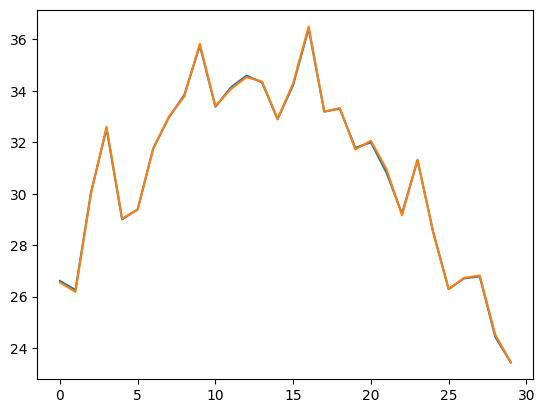

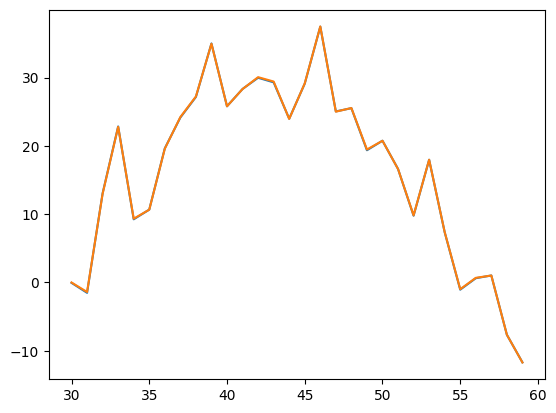

,y_predicted_price,y_actual_price
0,26.611187,26.55
1,26.259153,26.18
2,30.050604,30.00
3,32.527931,32.60
4,29.002308,29.03
5,29.387747,29.38
6,31.753973,31.75


,y_predicted_percentage,y_actual_percentage
0,32.954399,32.98
1,33.834877,33.78
2,35.754864,35.83
3,33.378811,33.40
4,34.132942,34.07
5,34.591267,34.53
6,34.325047,34.36
7,32.893242,32.91
8,34.219955,34.29
9,36.419655,36.50


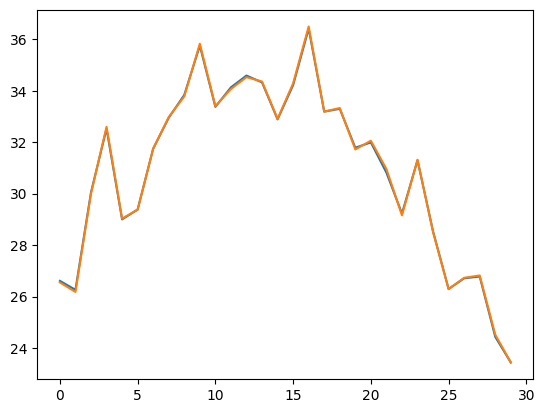

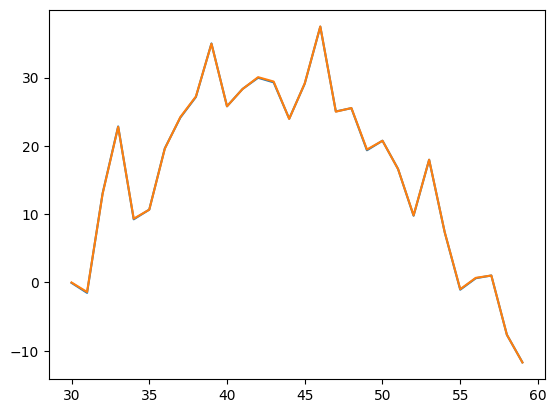

,y_predicted_price,y_actual_price
0,26.610022,26.55
1,26.261864,26.18
2,30.050014,30.00
3,32.525539,32.60
4,29.000834,29.03
5,29.383057,29.38
6,31.751808,31.75


,y_predicted_percentage,y_actual_percentage
0,32.950329,32.98
1,33.839069,33.78
2,35.754486,35.83
3,33.375328,33.40
4,34.133854,34.07
5,34.591759,34.53
6,34.326035,34.36
7,32.889507,32.91
8,34.218674,34.29
9,36.416588,36.50


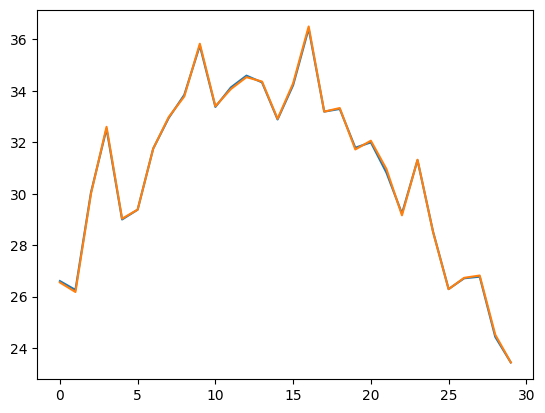

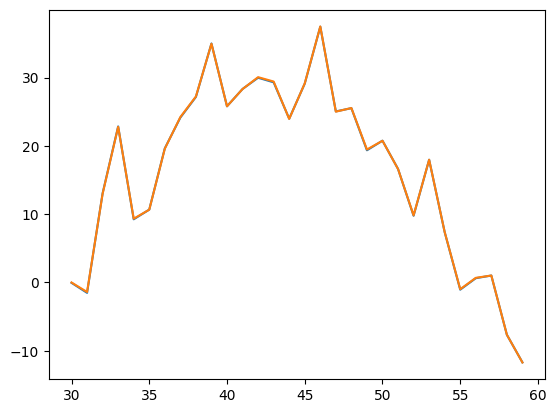

,y_predicted_price,y_actual_price
0,26.604490,26.55
1,26.260900,26.18
2,30.050146,30.00
3,32.523724,32.60
4,28.998564,29.03
5,29.378555,29.38
6,31.751894,31.75


,y_predicted_percentage,y_actual_percentage
0,32.945145,32.98
1,33.842037,33.78
2,35.755745,35.83
3,33.372662,33.40
4,34.132713,34.07
5,34.589203,34.53
6,34.326904,34.36
7,32.885887,32.91
8,34.217552,34.29
9,36.416420,36.50


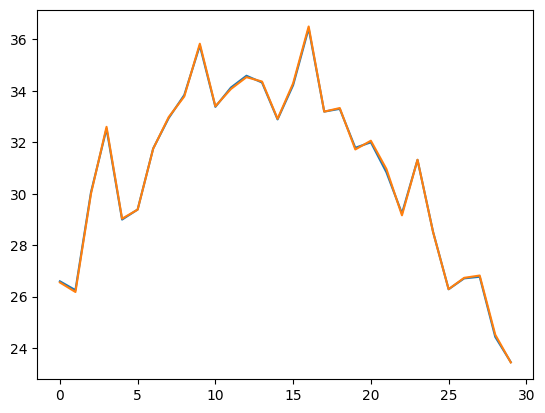

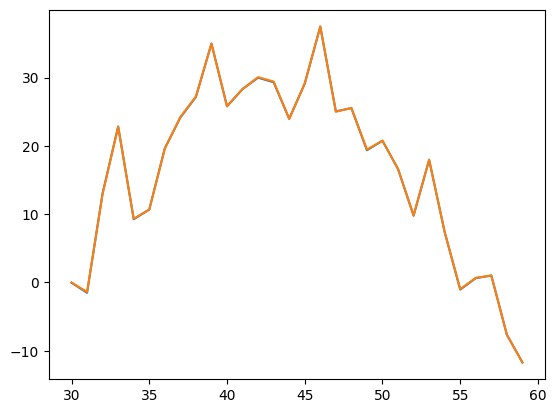

,y_predicted_price,y_actual_price
0,26.595543,26.55
1,26.253185,26.18
2,30.055767,30.00
3,32.526615,32.60
4,28.994522,29.03
5,29.385141,29.38
6,31.757742,31.75


,y_predicted_percentage,y_actual_percentage
0,32.941582,32.98
1,33.836548,33.78
2,35.757652,35.83
3,33.375549,33.40
4,34.126446,34.07
5,34.585060,34.53
6,34.321049,34.36
7,32.888184,32.91
8,34.218544,34.29
9,36.425026,36.50


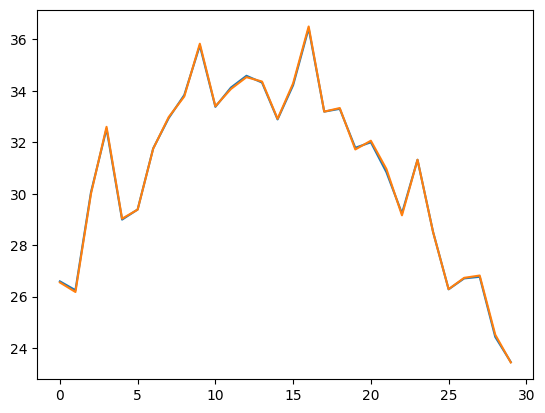

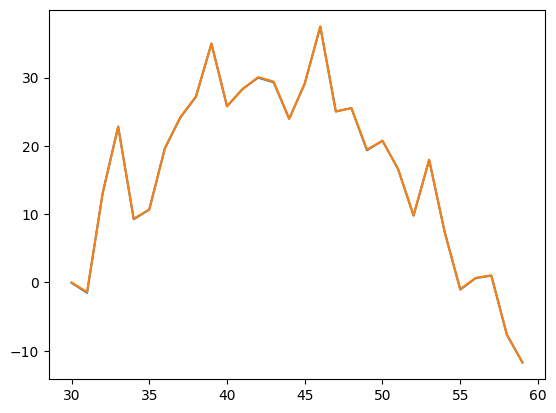

,y_predicted_price,y_actual_price
0,26.593071,26.55
1,26.250782,26.18
2,30.057825,30.00
3,32.526039,32.60
4,28.993570,29.03
5,29.386404,29.38
6,31.760216,31.75


,y_predicted_percentage,y_actual_percentage
0,32.940357,32.98
1,33.835590,33.78
2,35.758682,35.83
3,33.376152,33.40
4,34.125416,34.07
5,34.583412,34.53
6,34.319637,34.36
7,32.887890,32.91
8,34.217815,34.29
9,36.427193,36.50


In [31]:
test_predictions_unscaled =  scaler_labels.inverse_transform(test_predictions)
y_test_unscaled = scaler_labels.inverse_transform(y_test)
for i in range(5):  
    plot_predictions(test_predictions_unscaled[i], y_test_unscaled[i])
    predictions_table(test_predictions_unscaled[i], y_test_unscaled[i])

## Save model on registry

In [51]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

In [71]:
model_dir = "solana_price_daily_model_1"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
images_dir = model_dir + "/images"
if not os.path.exists(images_dir):
    os.mkdir(images_dir)

In [72]:
mr = project.get_model_registry()


# Creating input and output schemas using the 'Schema' class for features (X) and target variable (y)
input_schema = Schema(X_train)
output_schema = Schema(y_train)

# Creating a model schema using 'ModelSchema' with the input and output schemas
model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)

# Converting the model schema to a dictionary representation
schema_dict = model_schema.to_dict()


sample_indices = np.random.choice(X_test.shape[0], size=17, replace=False)
sample_test_values = X_test[sample_indices]

solana_model_1 = mr.python.create_model(
    name="solana_price_daily_model_1", 
    metrics= res_dict,
    model_schema=model_schema,
    input_example=sample_test_values, 
    description="Solana daily price predictor",
)

model_dir = "solana_price_daily_model_1"

solana_model_1.save(model_dir)

Uploading: 100.000%|██████████| 56202/56202 elapsed<00:02 remaining<00:0002,  1.76it/s]
Uploading: 100.000%|██████████| 216/216 elapsed<00:01 remaining<00:00
Model export complete: 100%|██████████| 6/6 [00:11<00:00,  1.92s/it]                   

Model created, explore it at https://c.app.hopsworks.ai:443/p/1164448/models/solana_price_daily_model_1/1


Model(name: 'solana_price_daily_model_1', version: 1)

In [56]:
X_test.shape

(192, 10, 17)